In [1]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from ase.io import read, write
from rascal.representations import SphericalInvariants as SOAP
from sklearn.kernel_ridge import KernelRidge

ModuleNotFoundError: No module named 'numpy'

In [2]:
def center_shifts(s):
    elements = [1, 6, 7]
    names = ['glycine_alpha', 'glycine_beta', 'glycine_gamma']
    for el in elements:
        for name in names:
            s[name][el] = np.mean(s[name][el]) - s[name][el]
    return s


shifts = {
    'glycine_alpha': {
        1: np.array([4.2, 3.1, 8.4]),
        6: np.array([176.5, 43.4]),
        7: np.array([32.3])
    },
    'glycine_beta': {
        1: np.array([2.5, 2.2, 7.4]),
        6: np.array([175.5, 43.2]),
        7: np.array([31.8])
    },
    'glycine_gamma': {
        1: np.array([3.3, 3.1, 8.8]),
        6: np.array([174.5, 42.4]),
        7: np.array([32.9])
    }
}

shifts = center_shifts(shifts)
shifts = center_shifts(shifts)

In [3]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4,
              max_radial=6,
              max_angular=4,
              gaussian_sigma_constant=0.5,
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=3.5,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=False,
              compute_gradients=False
              )

soap = SOAP(**hypers)

In [4]:
path_to_file = "PI_NVT/glycine_shieldings/"
path_to_init_file = "PI_NVT/"
colors =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [5]:
base_fn = lambda poly: path_to_file + f'pi_nvt_lmp_glycine_{poly}_300K_00_w_cs.xyz'
alpha_traj = read(base_fn('alpha'),':')
gamma_traj = read(base_fn('gamma'),':')
beta_traj = read(base_fn('beta'),':')


base_init_fn = lambda poly: path_to_init_file + f'glycine_{poly}/{poly}_init.xyz'
alpha_shieldings = read(base_init_fn("alpha"), ":" )[0].get_array("shieldings")
beta_shieldings = read(base_init_fn("beta"), ":" )[0].get_array("shieldings")
gamma_shieldings = read(base_init_fn("gamma"), ":" )[0].get_array("shieldings")

In [100]:
def process(traj, shieldings):
    for frame in traj:
        frame.wrap(eps=1E-10)
        frame.set_array("center_atoms_mask", None)

    number = traj[0].numbers
    X = soap.transform(traj).get_features(soap)

    no_atoms = len(number)
    
    X = X.reshape(len(traj), no_atoms, X.shape[1])

    X_averaged = np.mean(X, axis=0)

    output_cs = {}
    output_X = {}

    for species in [1, 6, 7, 8]:
        output_cs[species] = []
        output_X[species] = []
        types = shieldings[np.where(number == species)[0]] 
        for type in np.unique(types):
            output_cs[species].append(np.mean(np.concatenate([frame.arrays['CS'][np.where((np.logical_and(frame.numbers==species, shieldings == type)))[0]] for frame in traj]))) 
            output_X[species].append(np.mean(X_averaged[np.where((np.logical_and(frame.numbers==species, shieldings == type)))[0],:] , axis=0))    
        output_cs[species] = np.array(output_cs[species])
        output_X[species] = np.array(output_X[species])
    return output_cs, output_X 

# 3 fold model with 2 glycines as train and 1 as test set
def pred_3_folds(X_train, X_test, y_train, y_test, separate_models = True):

    alphas = np.logspace(-8, 4)

    # RMSE for 3 H shieldings of the test set (H1, H2 and H3) 
    # 6 Hs in train set (i.e. 2 of each shielding type)
    errors = np.zeros(len(alphas))

    # RSE for separately for all three Hs (H1, H2, H3) of the test set 
    errors_sep = np.zeros((len(alphas), len(y_test)))

    # RSE for separately for all three Hs (H1, H2, H3) of the test set with training models separately for all 3 Hs (H1, H2, H3) 
    # train sets (2 Hs per train set)
    errors_sep_sep = np.zeros((len(alphas), len(y_test)))

    
    for ai, alpha in enumerate(alphas):
        reg = KernelRidge(alpha=alpha, kernel="cosine")
        reg.fit(X_train, y_train)
        errors[ai] = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))
        errors_sep[ai] = [np.sqrt(mean_squared_error(i, j)) for i, j in zip( y_test, reg.predict(X_test) )]
        
        if separate_models:
            for i in range(len(y_test)):
                reg = KernelRidge(alpha=alpha, kernel="cosine")
                reg.fit( X_train[(i, i + len(y_test)), :] , np.take(y_train, [i, i + len(y_test)]).reshape(-1, 1))
                errors_sep_sep[ai][i] =  np.sqrt( mean_squared_error( y_test[i], reg.predict(X_test)[i] ) ) 


    return alphas, errors, errors_sep, errors_sep_sep




def pred_3_folds_validated(X_train, X_test, y_train, y_test):


    alphas = np.logspace(-8, 4)
    errors = np.zeros(len(alphas))

    for i in range(2):
        j = (i + 1)%2
        X_val = X_train[i*len(y_test):i*len(y_test) + len(y_test), :]
        X_train_fold = X_train[j*len(y_test):j*len(y_test) + len(y_test), :]
        y_val = y_train[i*len(y_test):i*len(y_test) + len(y_test)]
        y_train_fold = y_train[j*len(y_test):j*len(y_test) + len(y_test)]
    
        for ai, alpha in enumerate(alphas):
            reg = KernelRidge(alpha=alpha, kernel="cosine")
            reg.fit(X_train_fold, y_train_fold)
            errors[ai] += np.sqrt(mean_squared_error(y_val, reg.predict(X_val)))

    alpha_val = np.argmin(errors)

    reg = KernelRidge(alpha=alphas[alpha_val], kernel="cosine")
    reg.fit(X_train, y_train)

    final_error  = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))


    return final_error 

In [7]:
# download and average SOAPs and shieldings for all three glycines
cs_alpha, X_alpha = process(alpha_traj, alpha_shieldings)
cs_beta, X_beta = process(beta_traj, beta_shieldings)
cs_gamma, X_gamma = process(gamma_traj, gamma_shieldings)

ALPHA: 0.09346882773134231 - 0.11596894890936509  RMSE:  0.1082655243409783   BASELINE: 0.11597305181668925
BETA: 0.1193374378021332 - 0.24307532884171965  RMSE:  0.1202115400097816 BASELINE: 0.24307964780445268
GAMMA: 0.1344138819518891 - 0.23731163243524567  RMSE:  0.20806597333602003   BASELINE: 0.23731575963720652


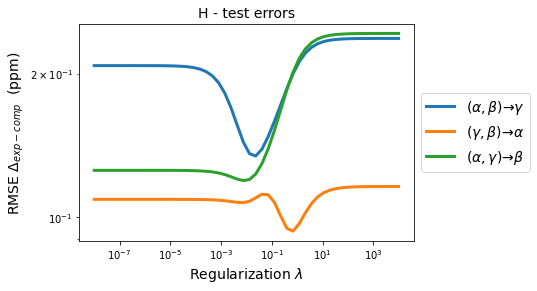

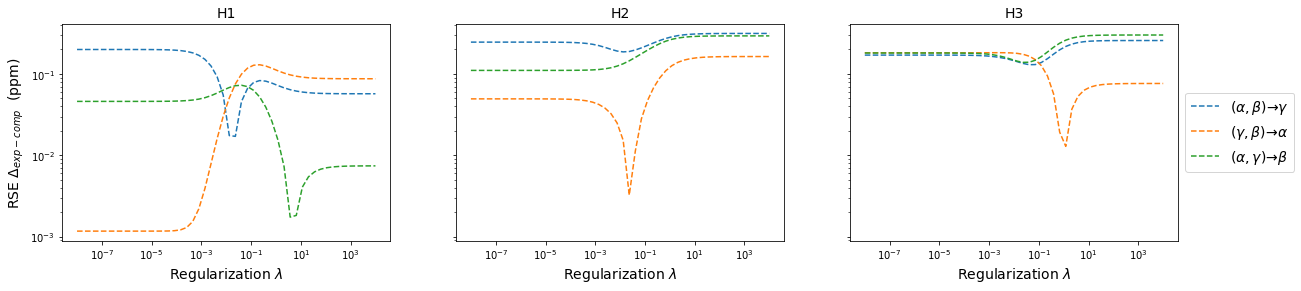

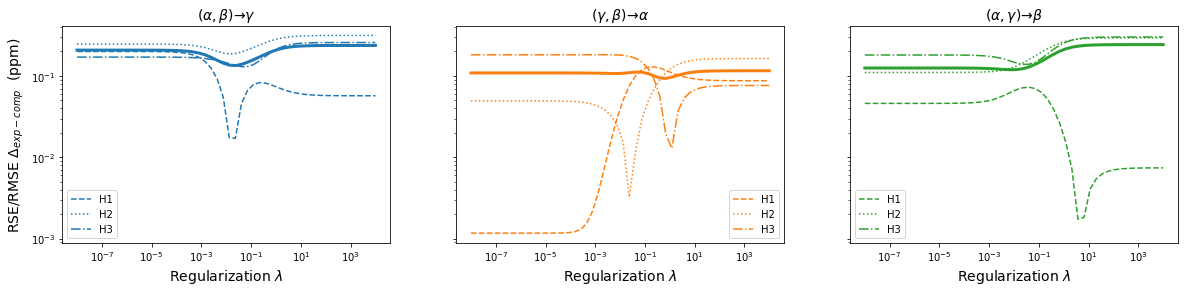

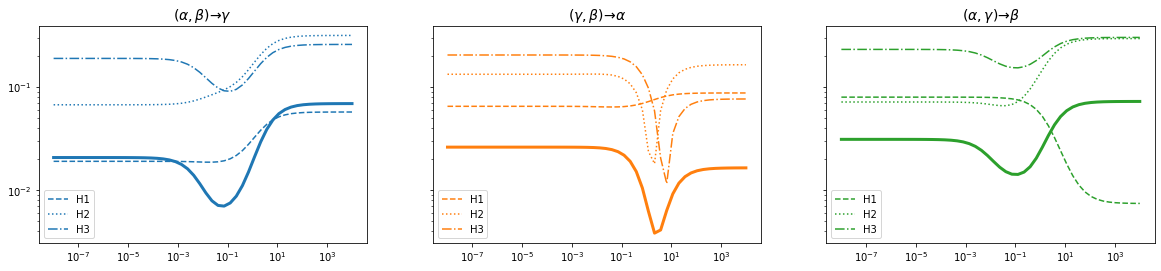

In [102]:
species = 1

# compute compuational shifts from shieldings (similarly to Edgars paper)

csh_alpha = cs_alpha[species].mean() - cs_alpha[species]
csh_gamma = cs_gamma[species].mean() - cs_gamma[species]
csh_beta = cs_beta[species].mean() - cs_beta[species]


# compute deltas (difference between experimental and computational)

delta_alpha = shifts['glycine_alpha'][species] - csh_alpha
delta_gamma = shifts['glycine_gamma'][species] - csh_gamma
delta_beta = shifts['glycine_beta'][species] - csh_beta


# compute RMSE for all three folds

alphas, errors_gamma, errors_gamma_sep, errors_gamma_sep_sep  = pred_3_folds(np.array([*X_alpha[species], *X_beta[species]]), X_gamma[species], np.array([*delta_alpha, *delta_beta]).reshape(-1, 1), delta_gamma.reshape(-1, 1))
_ , errors_alpha, errors_alpha_sep, errors_alpha_sep_sep  = pred_3_folds(np.array([*X_gamma[species], *X_beta[species]]), X_alpha[species], np.array([*delta_gamma, *delta_beta]).reshape(-1, 1), delta_alpha.reshape(-1, 1))
_ , errors_beta, errors_beta_sep, errors_beta_sep_sep  = pred_3_folds(np.array([*X_alpha[species], *X_gamma[species]]), X_beta[species], np.array([*delta_alpha, *delta_gamma]).reshape(-1, 1), delta_beta.reshape(-1, 1))


final_error_gamma = pred_3_folds_validated(np.array([*X_alpha[species], *X_beta[species]]), X_gamma[species], np.array([*delta_alpha, *delta_beta]).reshape(-1, 1), delta_gamma.reshape(-1, 1))
final_error_alpha = pred_3_folds_validated(np.array([*X_gamma[species], *X_beta[species]]), X_alpha[species], np.array([*delta_gamma, *delta_beta]).reshape(-1, 1), delta_alpha.reshape(-1, 1))
final_error_beta  = pred_3_folds_validated(np.array([*X_alpha[species], *X_gamma[species]]), X_beta[species], np.array([*delta_alpha, *delta_gamma]).reshape(-1, 1), delta_beta.reshape(-1, 1))


# draw figure for all three folds for the RMSE

plt.loglog(alphas, errors_gamma, label=r'$(\alpha, \beta) \to \gamma$', color=colors[0], linewidth = 3.0)
plt.loglog(alphas, errors_alpha, label=r'$(\gamma, \beta)\to \alpha$',  color=colors[1], linewidth = 3.0)
plt.loglog(alphas, errors_beta, label=r'$(\alpha, \gamma) \to \beta$', color=colors[2], linewidth = 3.0)

plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("H - test errors", fontsize=14)
plt.xlabel(r"Regularization $\lambda$", fontsize=14)
plt.ylabel(r"RMSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)

print("ALPHA: " + str(min(errors_alpha)) + " - "+  str(max(errors_alpha)) + "  RMSE:  " + str(final_error_alpha) + "   BASELINE: " + str(np.sqrt(mean_squared_error(np.zeros(delta_alpha.shape),delta_alpha))))
print("BETA: " + str(min(errors_beta)) + " - "+  str(max(errors_beta)) + "  RMSE:  " + str(final_error_beta) +   " BASELINE: " + str(np.sqrt(mean_squared_error(np.zeros(delta_beta.shape),delta_beta))))
print("GAMMA: " + str(min(errors_gamma)) + " - "+  str(max(errors_gamma)) + "  RMSE:  " + str(final_error_gamma) + "   BASELINE: " + str(np.sqrt(mean_squared_error(np.zeros(delta_gamma.shape),delta_gamma))))

# draw figure separately for different shieldings

fig, ax = plt.subplots(ncols=len(delta_alpha), nrows=1, sharey=True)
fig.set_figheight(4)
fig.set_figwidth(20)

for i in range(len(delta_alpha)):
    ax[i].loglog(alphas, errors_gamma_sep[:, i], color=colors[0], linestyle="dashed", label=r'$(\alpha, \beta) \to \gamma$')
    ax[i].loglog(alphas, errors_alpha_sep[:, i], color=colors[1], linestyle="dashed", label = r'$(\gamma, \beta)\to \alpha$')
    ax[i].loglog(alphas, errors_beta_sep[:, i], color=colors[2], linestyle="dashed", label = r'$(\alpha, \gamma) \to \beta$')
    ax[i].set_title("H" + str(i + 1), fontsize=14)
    ax[i].set_xlabel(r"Regularization $\lambda$", fontsize=14)
ax[0].set_ylabel(r"RSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)
ax[2].legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))

# draw figure separately for different crossvalidation folds

fig1, ax1 = plt.subplots(ncols=len(delta_alpha), nrows=1, sharey=True)
fig1.set_figheight(4)
fig1.set_figwidth(20)

linestyles = ["dashed", "dotted", "dashdot"]

errors_ave = [errors_gamma, errors_alpha, errors_beta]
errors_shield = [errors_gamma_sep, errors_alpha_sep, errors_beta_sep]
names = [r'$(\alpha, \beta) \to \gamma$', r'$(\gamma, \beta)\to \alpha$', r'$(\alpha, \gamma) \to \beta$']

for i in range(len(errors_ave)):
    ax1[i].loglog(alphas, errors_ave[i], color=colors[i], linewidth = 3.0)
    for j in range(len(delta_alpha)):
        ax1[i].loglog(alphas, errors_shield[i][:, j], color=colors[i], linestyle=linestyles[j], label = "H" + str(j + 1))
    ax1[i].set_title(names[i], fontsize=14)
    ax1[i].legend()
    ax1[i].set_xlabel(r"Regularization $\lambda$", fontsize=14)
ax1[0].set_ylabel(r"RSE/RMSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)

# Draw figure for separated shieldings models

fig2, ax2 = plt.subplots(ncols=len(delta_alpha), nrows=1, sharey=True)
fig2.set_figheight(4)
fig2.set_figwidth(20)

errors_ave = []
errors_shield = [errors_gamma_sep_sep, errors_alpha_sep_sep, errors_beta_sep_sep]

for i in errors_shield:     
    errors_ave.append(np.sqrt(np.mean([j**4 for j in i], 1)))

names = [r'$(\alpha, \beta) \to \gamma$', r'$(\gamma, \beta)\to \alpha$', r'$(\alpha, \gamma) \to \beta$']



for i in range(len(errors_ave)):
    ax2[i].loglog(alphas, errors_ave[i], color=colors[i], linewidth = 3.0)
    for j in range(len(delta_alpha)):
        ax2[i].loglog(alphas, errors_shield[i][:, j], color=colors[i], linestyle=linestyles[j], label = "H" + str(j + 1))
    ax2[i].set_title(names[i], fontsize=14)
    ax2[i].legend()
a = 1


Text(0, 0.5, 'RMSE $\\Delta_{exp - comp}$  (ppm)')

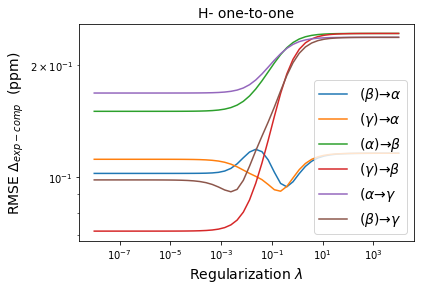

In [99]:
species = 1

csh_alpha = cs_alpha[species].mean() - cs_alpha[species]
csh_gamma = cs_gamma[species].mean() - cs_gamma[species]
csh_beta = cs_beta[species].mean() - cs_beta[species]


delta_alpha = shifts['glycine_alpha'][species] - csh_alpha
delta_gamma = shifts['glycine_gamma'][species] - csh_gamma
delta_beta = shifts['glycine_beta'][species] - csh_beta


alphas, errors_alpha_gamma, _, _ = pred_3_folds(X_alpha[species], X_gamma[species], delta_alpha.reshape(-1, 1), delta_gamma.reshape(-1, 1),False)
_ , errors_alpha_beta, _, _ = pred_3_folds(X_alpha[species], X_beta[species], delta_alpha.reshape(-1, 1),  delta_beta.reshape(-1, 1),False)
_ , errors_beta_alpha, _, _= pred_3_folds(X_beta[species], X_alpha[species], delta_beta.reshape(-1, 1), delta_alpha.reshape(-1, 1),False)
_ , errors_beta_gamma, _, _ = pred_3_folds(X_beta[species], X_gamma[species], delta_beta.reshape(-1, 1), delta_gamma.reshape(-1, 1),False)
_ , errors_gamma_alpha, _, _= pred_3_folds(X_gamma[species], X_alpha[species], delta_gamma.reshape(-1, 1), delta_alpha.reshape(-1, 1),False)
_ , errors_gamma_beta, _, _= pred_3_folds(X_gamma[species], X_beta[species], delta_gamma.reshape(-1, 1), delta_beta.reshape(-1, 1),False)


plt.loglog(alphas, errors_beta_alpha, label=r'$(\beta) \to \alpha$')
plt.loglog(alphas, errors_gamma_alpha, label=r'$(\gamma) \to \alpha$')
plt.loglog(alphas, errors_alpha_beta, label=r'$(\alpha) \to \beta$')
plt.loglog(alphas, errors_gamma_beta, label=r'$(\gamma) \to \beta$')
plt.loglog(alphas, errors_alpha_gamma, label=r'$(\alpha \to \gamma$')
plt.loglog(alphas, errors_beta_gamma, label=r'$(\beta) \to \gamma$')

plt.legend(fontsize=14)
plt.title("H- one-to-one", fontsize=14)
plt.xlabel(r"Regularization $\lambda$", fontsize=14)
plt.ylabel(r"RMSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)

ALPHA: 0.219104701749812 - 0.9291211703262864  RMSE:  0.34035978537331213   BASELINE: 0.929179324832873
BETA: 0.025905495835051116 - 0.8352576372391322  RMSE:  0.22107627335316735 BASELINE: 0.835321128664873
GAMMA: 0.01461970734353632 - 0.6266764767356534  RMSE:  0.24225076166644163   BASELINE: 0.6267494066306654


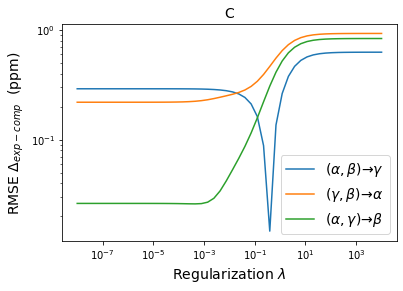

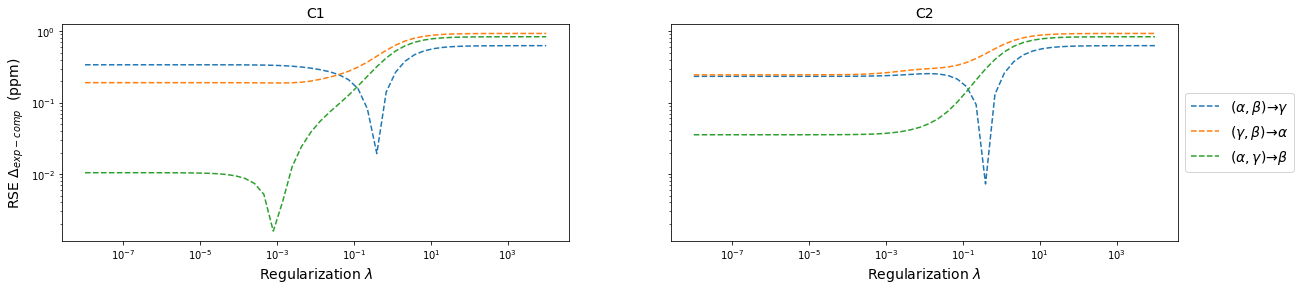

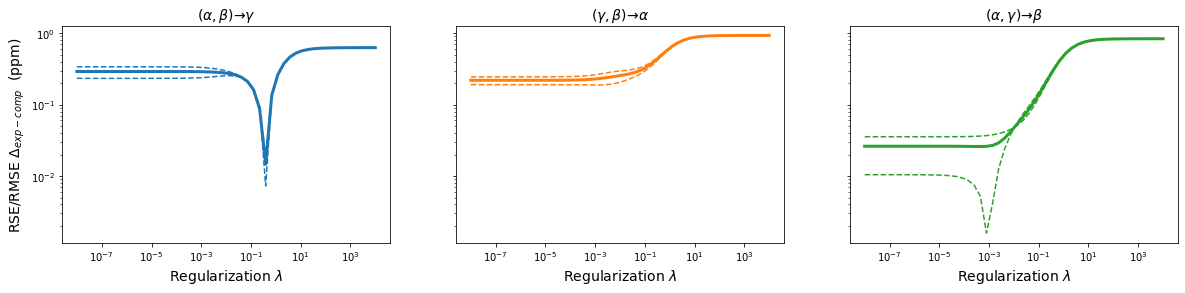

In [107]:
species = 6

csh_alpha = cs_alpha[species].mean() - cs_alpha[species]
csh_gamma = cs_gamma[species].mean() - cs_gamma[species]
csh_beta = cs_beta[species].mean() - cs_beta[species]


delta_alpha = shifts['glycine_alpha'][species] - csh_alpha
delta_gamma = shifts['glycine_gamma'][species] - csh_gamma
delta_beta = shifts['glycine_beta'][species] - csh_beta

alphas, errors_gamma, errors_gamma_sep, errors_gamma_sep_sep  = pred_3_folds(np.array([*X_alpha[species], *X_beta[species]]), X_gamma[species], np.array([*delta_alpha, *delta_beta]).reshape(-1, 1), delta_gamma.reshape(-1, 1))
_ , errors_alpha, errors_alpha_sep, errors_alpha_sep_sep  = pred_3_folds(np.array([*X_gamma[species], *X_beta[species]]), X_alpha[species], np.array([*delta_gamma, *delta_beta]).reshape(-1, 1), delta_alpha.reshape(-1, 1))
_ , errors_beta, errors_beta_sep, errors_beta_sep_sep  = pred_3_folds(np.array([*X_alpha[species], *X_gamma[species]]), X_beta[species], np.array([*delta_alpha, *delta_gamma]).reshape(-1, 1), delta_beta.reshape(-1, 1))

plt.loglog(alphas, errors_gamma, label=r'$(\alpha, \beta) \to \gamma$')
plt.loglog(alphas, errors_alpha, label=r'$(\gamma, \beta)\to \alpha$')
plt.loglog(alphas, errors_beta, label=r'$(\alpha, \gamma) \to \beta$')

final_error_gamma = pred_3_folds_validated(np.array([*X_alpha[species], *X_beta[species]]), X_gamma[species], np.array([*delta_alpha, *delta_beta]).reshape(-1, 1), delta_gamma.reshape(-1, 1))
final_error_alpha = pred_3_folds_validated(np.array([*X_gamma[species], *X_beta[species]]), X_alpha[species], np.array([*delta_gamma, *delta_beta]).reshape(-1, 1), delta_alpha.reshape(-1, 1))
final_error_beta  = pred_3_folds_validated(np.array([*X_alpha[species], *X_gamma[species]]), X_beta[species], np.array([*delta_alpha, *delta_gamma]).reshape(-1, 1), delta_beta.reshape(-1, 1))

plt.legend(fontsize=14)
plt.title("C", fontsize=14)
plt.xlabel(r"Regularization $\lambda$", fontsize=14)
plt.ylabel(r"RMSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)

print("ALPHA: " + str(min(errors_alpha)) + " - "+  str(max(errors_alpha)) + "  RMSE:  " + str(final_error_alpha) + "   BASELINE: " + str(np.sqrt(mean_squared_error(np.zeros(delta_alpha.shape),delta_alpha))))
print("BETA: " + str(min(errors_beta)) + " - "+  str(max(errors_beta)) + "  RMSE:  " + str(final_error_beta) +   " BASELINE: " + str(np.sqrt(mean_squared_error(np.zeros(delta_beta.shape),delta_beta))))
print("GAMMA: " + str(min(errors_gamma)) + " - "+  str(max(errors_gamma)) + "  RMSE:  " + str(final_error_gamma) + "   BASELINE: " + str(np.sqrt(mean_squared_error(np.zeros(delta_gamma.shape),delta_gamma))))

# draw figure separately for different shieldings

fig, ax = plt.subplots(ncols=len(delta_alpha), nrows=1, sharey=True)
fig.set_figheight(4)
fig.set_figwidth(20)

for i in range(len(delta_alpha)):
    ax[i].loglog(alphas, errors_gamma_sep[:, i], color=colors[0], linestyle="dashed", label=r'$(\alpha, \beta) \to \gamma$')
    ax[i].loglog(alphas, errors_alpha_sep[:, i], color=colors[1], linestyle="dashed", label = r'$(\gamma, \beta)\to \alpha$')
    ax[i].loglog(alphas, errors_beta_sep[:, i], color=colors[2], linestyle="dashed", label = r'$(\alpha, \gamma) \to \beta$')
    ax[i].set_title("C" + str(i + 1), fontsize=14)
    ax[i].set_xlabel(r"Regularization $\lambda$", fontsize=14)
ax[0].set_ylabel(r"RSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)
ax[1].legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))

# draw figure separately for different crossvalidation folds

fig1, ax1 = plt.subplots(ncols=3, nrows=1, sharey=True)
fig1.set_figheight(4)
fig1.set_figwidth(20)

errors_ave = [errors_gamma, errors_alpha, errors_beta]
errors_shield = [errors_gamma_sep, errors_alpha_sep, errors_beta_sep]
names = [r'$(\alpha, \beta) \to \gamma$', r'$(\gamma, \beta)\to \alpha$', r'$(\alpha, \gamma) \to \beta$']

for i in range(len(errors_ave)):
    ax1[i].loglog(alphas, errors_ave[i], color=colors[i], linewidth = 3.0)
    for j in range(len(delta_alpha)):
        ax1[i].loglog(alphas, errors_shield[i][:, j], color=colors[i], linestyle="dashed")
    ax1[i].set_title(names[i], fontsize=14)
    ax1[i].set_xlabel(r"Regularization $\lambda$", fontsize=14)
ax1[0].set_ylabel(r"RSE/RMSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)

# Draw figure for separated shieldings models
"""
fig2, ax2 = plt.subplots(ncols=len(delta_alpha), nrows=1, sharey=True)
fig2.set_figheight(4)
fig2.set_figwidth(20)

errors_ave = []
errors_shield = [errors_gamma_sep_sep, errors_alpha_sep_sep, errors_beta_sep_sep]

for i in errors_shield:     
    errors_ave.append(np.sqrt(np.mean([j**4 for j in i], 1)))

names = [r'$(\alpha, \beta) \to \gamma$', r'$(\gamma, \beta)\to \alpha$', r'$(\alpha, \gamma) \to \beta$']

for i in range(len(errors_ave)):
    ax2[i].loglog(alphas, errors_ave[i], color=colors[i], linewidth = 3.0)
    for j in range(len(delta_alpha)):
        ax2[i].loglog(alphas, errors_shield[i][:, j], color=colors[i], linestyle="dashed")
    ax2[i].set_title(names[i], fontsize=14)
"""
a = 1


In [109]:
delta_alpha,delta_beta, delta_gamma,

(array([-0.92917932,  0.92917932]),
 array([-0.83532113,  0.83532113]),
 array([-0.62674941,  0.62674941]))

Text(0, 0.5, 'RMSE $\\Delta_{exp - comp}$  (ppm)')

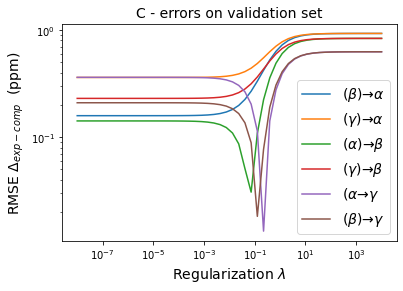

In [98]:
species = 6

csh_alpha = cs_alpha[species].mean() - cs_alpha[species]
csh_gamma = cs_gamma[species].mean() - cs_gamma[species]
csh_beta = cs_beta[species].mean() - cs_beta[species]


delta_alpha = shifts['glycine_alpha'][species] - csh_alpha
delta_gamma = shifts['glycine_gamma'][species] - csh_gamma
delta_beta = shifts['glycine_beta'][species] - csh_beta


alphas, errors_alpha_gamma, _, _ = pred_3_folds(X_alpha[species], X_gamma[species], delta_alpha.reshape(-1, 1), delta_gamma.reshape(-1, 1),False)
_ , errors_alpha_beta, _, _ = pred_3_folds(X_alpha[species], X_beta[species], delta_alpha.reshape(-1, 1),  delta_beta.reshape(-1, 1),False)
_ , errors_beta_alpha, _, _= pred_3_folds(X_beta[species], X_alpha[species], delta_beta.reshape(-1, 1), delta_alpha.reshape(-1, 1),False)
_ , errors_beta_gamma, _, _ = pred_3_folds(X_beta[species], X_gamma[species], delta_beta.reshape(-1, 1), delta_gamma.reshape(-1, 1),False)
_ , errors_gamma_alpha, _, _= pred_3_folds(X_gamma[species], X_alpha[species], delta_gamma.reshape(-1, 1), delta_alpha.reshape(-1, 1),False)
_ , errors_gamma_beta, _, _= pred_3_folds(X_gamma[species], X_beta[species], delta_gamma.reshape(-1, 1), delta_beta.reshape(-1, 1),False)


plt.loglog(alphas, errors_beta_alpha, label=r'$(\beta) \to \alpha$')
plt.loglog(alphas, errors_gamma_alpha, label=r'$(\gamma) \to \alpha$')
plt.loglog(alphas, errors_alpha_beta, label=r'$(\alpha) \to \beta$')
plt.loglog(alphas, errors_gamma_beta, label=r'$(\gamma) \to \beta$')
plt.loglog(alphas, errors_alpha_gamma, label=r'$(\alpha \to \gamma$')
plt.loglog(alphas, errors_beta_gamma, label=r'$(\beta) \to \gamma$')

plt.legend(fontsize=14)
plt.title("C - one-to-one", fontsize=14)
plt.xlabel(r"Regularization $\lambda$", fontsize=14)
plt.ylabel(r"RMSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)

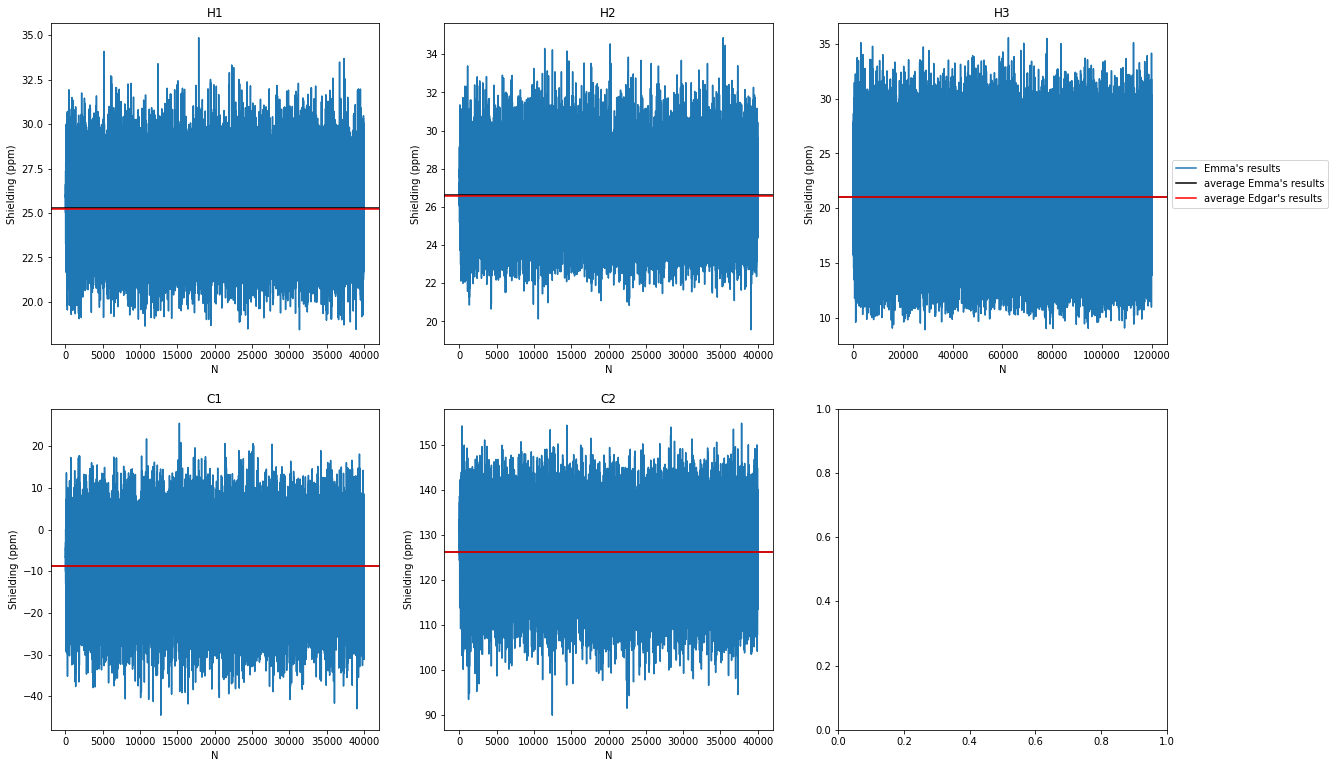

In [201]:
fig, ax = plt.subplots(ncols=3, nrows=2)
fig.set_figheight(13)
fig.set_figwidth(20)

edgars_results = {
    'glycine_alpha': {
        1 : np.array([25.24, 26.59, 21.07]),
        6 : np.array([-8.64, 126.26]),
        7 : np.array([191.82])
    },
    'glycine_beta': {
        1: np.array([26.13, 26.91, 21.16]),
        6: np.array([-5.73, 127.86]),
        7: np.array([194.45])
    },
    'glycine_gamma': {
        1 : np.array([26.53, 27.11, 20.86]),
        6 : np.array([-5.01, 128.34]),
        7 : np.array([191.37])
    }
}

edgars_errors = {
    'glycine_alpha': {
        1 : np.array([0.02, 0.02, 0.01]),
        6 : np.array([0.08, 0.07]),
        7 : np.array([0.15])
    },
    'glycine_beta': {
        1: np.array([0.25, 0.26, 0.21]),
        6: np.array([0.58, 0.64]),
        7: np.array([1.29])
    },
    'glycine_gamma': {
        1 : np.array([0.02, 0.02, 0.01]),
        6 : np.array([0.02, 0.02]),
        7 : np.array([0.01])
    }
}

labels = {1 : "H", 6: "C", 7 : "N", 8 : "O"}

for i, el in enumerate([1,6]):
    for j in range(len(edgars_results["glycine_alpha"][el])):
        cs = np.concatenate([frame.arrays['CS'][np.where(np.logical_and(frame.numbers==el, alpha_shieldings == j + 1))[0]] for frame in alpha_traj])
        ax[i][j].plot(cs, label="Emma's results")
        ax[i][j].axhline(np.mean(cs), c='k', label="average Emma's results")
        ax[i][j].axhline(edgars_results["glycine_alpha"][el][j], c='r', label="average Edgar's results")
        ax[i][j].set_title(labels[el] + str(j + 1))
        ax[i][j].set_ylabel("Shielding (ppm)")
        ax[i][j].set_xlabel("N")
        #ax[i][j].fill_between(range(len(cs[np.where(types==1)])), 25.22, 25.26, color='r', alpha=0.5)
ax[0][2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

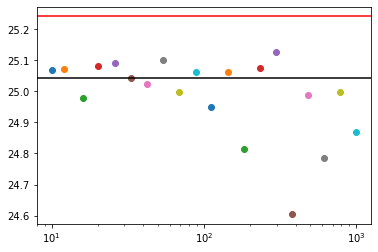

In [71]:
for j in np.logspace(1, 3, 20, dtype=int):
    plt.scatter(j, np.mean(cs[np.where(types==1)][10*j::j]))
plt.axhline(25.24, c='r')
plt.axhline(np.mean(cs[np.where(types==1)]), c='k')
plt.gca().set_xscale('log')